# Rapport -- Weblogs opdracht -- Floris Buyse -- G2E2
---

## Data begrijpen en cleanen
---
1. Data opsplitsen (95 / 5)
2. ID droppen
3. NaN-waarden zoeken in data
4. NaN-waarden wegkrijgen / oplossen (4 verschillende manieren getest)
5. Feature importance bekijken
6. Conclusie
7. Verdere stappen
---

### 1. Data opsplitsen (95 / 5)
- We gebruiken 95% voor het trainen en testen van verschillende machine learning models en de andere 5% voor het finaal model en voor hertraining van dit finaal model
  
  ```python
  half = int(df.shape[0] * 0.95)
  df1 = df.iloc[:half]
  df2 = df.iloc[half:]

  df1.to_csv('../data/weblogs1.csv', index=False)
  df2.to_csv('../data/weblogs2.csv', index=False)
  ```
    deze code is ook terug te vinden in ``main_scripts/split_csv.ipynb``

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./data/weblogs1.csv')

### 2. ID droppen

- ``ID heeft geen toegevoegde waarde aan de data.``

In [4]:
df = df.drop(['ID'], axis=1)

### 3. NaN-waaren zoeken in data

- ``We zien dat "STANDARD_DEVIATION", "SF_FILETYPE" en "SF_REFERRER" NaN-waarden hebben``

In [5]:
X = df.drop(['ROBOT'], axis=1)
y = df['ROBOT']

In [6]:
X.isna().sum()[X.isna().sum() > 0]

STANDARD_DEVIATION    13520
SF_REFERRER           13520
SF_FILETYPE           13520
dtype: int64

### 4. NaN-waarden wegkrijgen / oplossen

#### 4.1 De features opvullen met 0

- We vullen de features op met nul en vergelijken de standaard deviatie (niet de feature) met die van de 'niet-opgevulde' X

In [7]:
X_zero = X.copy()
X_zero = X.fillna(0)
print(f"X met 0 opgevuld:\n------------------\n{X_zero[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}\n")
print(f"X zonder 0 opgevuld:\n---------------------\n{X[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")

X met 0 opgevuld:
------------------
STANDARD_DEVIATION    81.412416
SF_REFERRER            0.241471
SF_FILETYPE            0.270922
dtype: float64

X zonder 0 opgevuld:
---------------------
STANDARD_DEVIATION    89.781873
SF_REFERRER            0.243797
SF_FILETYPE            0.248241
dtype: float64


Bij STANDARD_DEVIATION zien we een redelijk groot verschil

---

#### 4.2 De features opvullen met mean

- We vullen de features op met mean() en vergelijken de standaard deviatie (niet de feature) met die van de 'niet-opgevulde' X

In [8]:
X_mean = X.copy()
X_mean = X.fillna(X.mean())
print(f"\nX met mean opgevuld:\n---------------------\n{X_mean[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")
print(f"\nX zonder mean opgevuld:\n------------------------\n{X[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")


X met mean opgevuld:
---------------------
STANDARD_DEVIATION    79.733879
SF_REFERRER            0.216512
SF_FILETYPE            0.220459
dtype: float64

X zonder mean opgevuld:
------------------------
STANDARD_DEVIATION    89.781873
SF_REFERRER            0.243797
SF_FILETYPE            0.248241
dtype: float64


Een nog groter verschil bij STANDARD_DEVIATION, maar deze keer ook een groter verschil bij de SF_FILETYPE EN SF_REFERRER

---

#### 4.3 De features opvullen met SimpleImputer met strategy 'mean'

- We vullen de features op met mean via de SimpleImputer en vergelijken de standaard deviatie (niet de feature) met die van de 'niet-opgevulde' X

In [9]:
from sklearn.impute import SimpleImputer

X_imputed = X.copy()

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_imputed)
X_imputed = pd.DataFrame(imputer.transform(X_imputed), columns=X_imputed.columns)

print(f"\nX met imputer opgevuld:\n------------------------\n{X_imputed[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")
print(f"\nX zonder imputer opgevuld:\n---------------------------\n{X[['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE']].std()}")


X met imputer opgevuld:
------------------------
STANDARD_DEVIATION    79.733879
SF_REFERRER            0.216512
SF_FILETYPE            0.220459
dtype: float64

X zonder imputer opgevuld:
---------------------------
STANDARD_DEVIATION    89.781873
SF_REFERRER            0.243797
SF_FILETYPE            0.248241
dtype: float64


Er is geen verschil tussen het gebruik van 
```python 
X.fillna(X.mean())
``` 
en het gebruik van een 
```python
SimpleImputer(strategy="mean")
```

---

#### 4.4 De features met NaN-waarden droppen

- We droppen de features met NaN-waarden en testen ze uit op verschillende classificatiemodels

In [10]:
X_drop = X.copy()
X_drop = X.drop(['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE'], axis=1)

---

### 5. Feature importance bekijken

#### 5.1 Opsplitsen in train en test data

In [11]:
from sklearn.model_selection import train_test_split

X_zero_train, X_zero_test, y_train, y_test = train_test_split(X_zero, y, test_size=0.2, random_state=42)
X_mean_train, X_mean_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.2, random_state=42)
X_drop_train, X_drop_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2, random_state=42)

#### 5.2 DecisionTreeClassifier trainen op verschillende types data (X_zero, X_mean, X_drop)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def grid_test(type, X, y, cl_report):
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'max_depth': np.arange(2, 31)}, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    
    print(f"Decision Tree Classifier met {type}:\n------------------------------------")  

    print(grid_search.best_params_)

    y_pred = grid_search.predict(X)

    if cl_report:
        print(classification_report(y, y_pred))

    print(accuracy_score(y, y_pred))

    cm_mean = np.round(confusion_matrix(y, y_pred, normalize='true'), 2)

    print(cm_mean)
    print("------------------------------------")
    return grid_search.best_estimator_

#### 5.3 Feature Importance bekijken

Decision Tree Classifier met X_zero:
------------------------------------
{'max_depth': 15}
0.9864027975853245
[[0.99 0.01]
 [0.04 0.96]]
------------------------------------
Decision Tree Classifier met X_mean:
------------------------------------
{'max_depth': 15}
0.9862074354816652
[[0.99 0.01]
 [0.04 0.96]]
------------------------------------
Decision Tree Classifier met X_drop:
------------------------------------
{'max_depth': 16}
0.9873600718932541
[[0.99 0.01]
 [0.03 0.97]]
------------------------------------


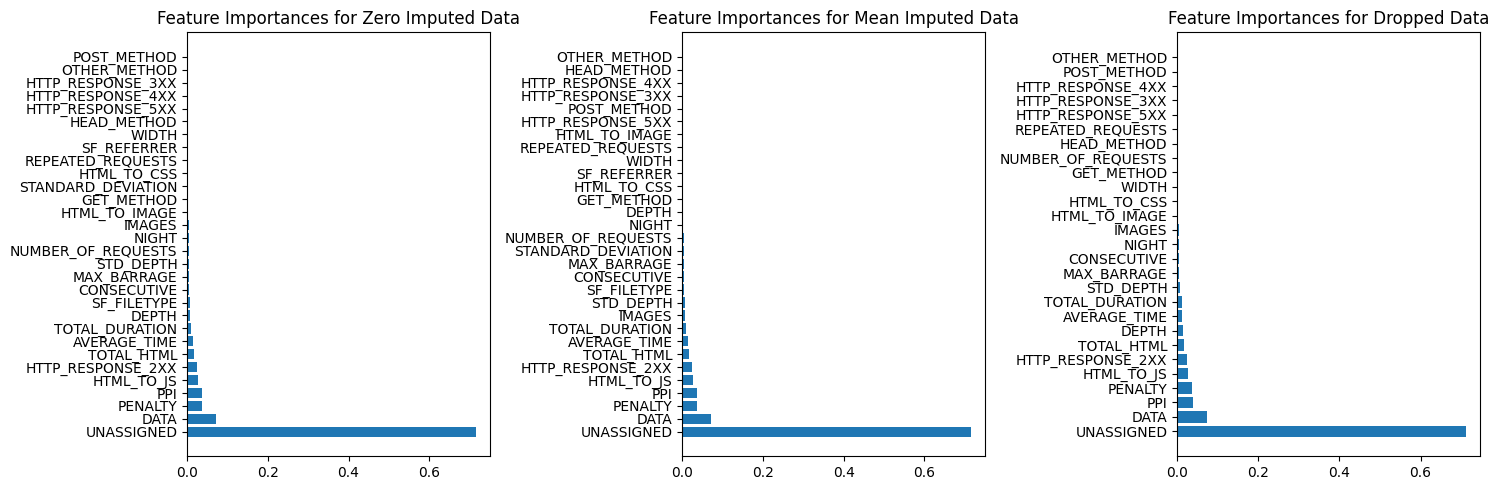

In [13]:
dt_clf_0 = grid_test("X_zero", X_zero_train, y_train, False)
dt_clf_0.fit(X_zero_train, y_train)

dt_clf_mean = grid_test("X_mean", X_mean_train, y_train, False)
dt_clf_mean.fit(X_mean_train, y_train)

dt_clf_drop = grid_test("X_drop", X_drop_train, y_train, False)
dt_clf_drop.fit(X_drop_train, y_train)

def feature_imp(clf, X):
    importances = clf.feature_importances_
    features = X.columns

    df_importances = pd.DataFrame({'feature': features, 'importance': importances})
    df_importances = df_importances.sort_values(by='importance', ascending=False)
    return df_importances

zero_importances = feature_imp(dt_clf_0, X_zero_train)
mean_importances = feature_imp(dt_clf_mean, X_mean_train)
drop_importances = feature_imp(dt_clf_drop, X_drop_train)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].barh(zero_importances['feature'], zero_importances['importance'])
ax[0].set_title('Feature Importances for Zero Imputed Data')

ax[1].barh(mean_importances['feature'], mean_importances['importance'])
ax[1].set_title('Feature Importances for Mean Imputed Data')

ax[2].barh(drop_importances['feature'], drop_importances['importance'])
ax[2].set_title('Feature Importances for Dropped Data')

plt.tight_layout()
plt.show()

Hier kunnen we duidelijk zien dat OTHER_METHOD, POST_METHOD, HEAD_METHOD, HTTP_RESPONSE(3,4,5)XX en REPEATED_REQUESTS geen importance hebben

#### 5.4 Features met weinig of geen importance droppen

In [14]:
X_zero = X.copy()
X_zero = X_zero.fillna(0)
X_zero = X_zero.drop(['OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

X_mean = X.copy()
X_mean = X_mean.fillna(X.mean())
X_mean = X_mean.drop(['OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

X_drop = X.copy()
X_drop = X.drop(['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

X_zero_train, X_zero_test, y_train, y_test = train_test_split(X_zero, y, test_size=0.2, random_state=42)
X_mean_train, X_mean_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.2, random_state=42)
X_drop_train, X_drop_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2, random_state=42)

#### 5.5 Opnieuw DecisionTreeClassifiers trainen en vergelijken met vorige

In [15]:
dt_clf_0 = grid_test("X_zero", X_zero_train, y_train, True)
dt_clf_0.fit(X_zero_train, y_train)

dt_clf_mean = grid_test("X_mean", X_mean_train, y_train, True)
dt_clf_mean.fit(X_mean_train, y_train)

dt_clf_drop = grid_test("X_drop", X_drop_train, y_train, True)
dt_clf_drop.fit(X_drop_train, y_train)

Decision Tree Classifier met X_zero:
------------------------------------
{'max_depth': 15}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     40990
           1       0.97      0.96      0.97     10197

    accuracy                           0.99     51187
   macro avg       0.98      0.98      0.98     51187
weighted avg       0.99      0.99      0.99     51187

0.9864027975853245
[[0.99 0.01]
 [0.04 0.96]]
------------------------------------
Decision Tree Classifier met X_mean:
------------------------------------
{'max_depth': 15}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     40990
           1       0.97      0.96      0.97     10197

    accuracy                           0.99     51187
   macro avg       0.98      0.98      0.98     51187
weighted avg       0.99      0.99      0.99     51187

0.9862074354816652
[[0.99 0.01]
 [0.04 0.96]]
---------------------------------

DecisionTreeClassifier(max_depth=15, random_state=42)

### 6. Conclusie

We zien geen grote verschillen tussen de verschillende DecisionTreeClassifiers. Het model getrained met de X_drop (waar de features met NaN-waarden gedropped zijn) heeft net iets betere resultaten dan de andere X'en (X_zero en X_mean). Na het droppen van de features met weinig importance was er een zeer lichte daling in recall en accuracy bij de DecisionTreeClassifier met X_drop.

### 7. Verdere stappen

- Nu ga ik aan de slag met de data, ik zal modellen trainen per soort (DecisionTree models & Andere soorten).
- Per onderdeel wordt er ook getest of scaling de resultaten verbeterd of niet
- Daarna zal ik tonen hoe goed (of slecht) het model het deed op de 5% achtergehouden data
- Deze scripts zijn te vinden in ``/main_scripts``

## DecisionTree Modellen
---

Script te vinden in ``/main_scripts/dec_trees_drop.ipynb``

1. DecisionTreeClassifier
2. BaggingClassifier zonder OOB
3. BaggingClassifier met OOB
4. AdaBoostClassifier
5. GradientBoostingClassifier
6. RandomForestClassifier

---

#### 1. DecisionTreeClassifier

- max_depth: maximale diepte van de boom (te weinig --> Niet accuraat genoeg | te veel / oneindig --> overfitting)
- min_samples_leaf: min. aantal samples nodig om een leaf node (= heeft geen children) te zijn
- min_samples_split: min. aantal of samples nodig om een interne node te splitsen

##### 1.1 Zonder scaling
---

**Best estimator (gridsearch)**: {'max_depth': 29, 'min_samples_leaf': 3, 'min_samples_split': 12}

**Accuracy**: 0.9766351488630147

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10337
           1       0.95      0.93      0.94      2460
```
**Confusion Matrix**

<img src="./images/dec_tree_drop_cm.png" height=30% width=30%>

##### 1.2 Met scaling
---

**Best estimator (gridsearch)**: {'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 16}

**Accuracy**: 0.9750722825662265

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10337
           1       0.93      0.94      0.94      2460
```

**Confusion Matrix**:

<img src="./images/dec_tree_scaled_drop_cm.png" height=30% width=30%>

##### 1.3 Test op 5% achtergehouden data
---

Aangezien de scaler de resultaten heeft verminderd zal ik alleen testen met de DecisionTreeClassifier zonder scaling

**Accuracy**: 96.97%

**Confusion matrix**:
```
 [[0.98 0.02]
 [0.07 0.93]]
```

#### 2. BaggingClassifier zonder OOB

- n_estimators: Aantal base estimators in de ensemble
- max_samples: aantal samples die van X worden gebruikt om elke base estimator te trainen
- bootstrap: of samples met replacement worden gebruikt of niet
- bootstrap_features: of features met replacement worden gebruikt of niet

##### 2.1 Zonder scaling
---

**Best estimator (gridsearch)**: {'bootstrap': False, 'bootstrap_features': True, 'max_samples': 30000, 'n_estimators': 100}

**Accuracy**: 0.9797608814565913

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.95      0.94      0.95      2460
```

<img src="./images/bag_clf_no_oob_no_scale_cm.png" height=30% width=30%>

##### 2.2 Met scaling
---

**Best estimator (gridsearch)**: {'bootstrap': True, 'bootstrap_features': True, 'max_samples': 30000, 'n_estimators': 500}

**Accuracy**: 0.9776510119559272

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10337
           1       0.95      0.93      0.94      2460
```

<img src="./images/bag_clf_no_oob_scale_cm.png" height=30% width=30%>

##### 2.3 Test op 5% achtergehouden data

Aangezien de scaler de resultaten heeft verminderd zal ik alleen testen met de BaggingClassifier zonder scaling

**Accuracy**: 97.09%

**Confusion matrix**:
```
 [[0.99 0.01]
 [0.07 0.93]]
```

#### 3. BaggingClassifier met OOB

- oob_score: of er out-of-bag samples worden gebruikt om de generalisatie error te bepalen (werkt alleen bij bootstrap=True)

##### 3.1 Zonder scaling
---

**Best estimator (gridsearch)**: {'max_samples': 15000, 'n_estimators': 10}

**OOB score**: 0.9761658233535859

**Accuracy**: 0.9777291552707665

**Classification Report**:
```
                precision    recall  f1-score   support

            0       0.98      0.99      0.99     10337
            1       0.95      0.94      0.94      2460
```
<img src="./images/bag_clf_oob_no_scale_cm.png" height=30% width=30%>

##### 3.2 Met scaling
---

**Best estimator (gridsearch)**: {'max_samples': 20000, 'n_estimators': 30}

**Accuracy**: 0.9764788622333359

**Classification Report**:
```
                precision    recall  f1-score   support

            0       0.98      0.99      0.99     10337
            1       0.95      0.93      0.94      2460
```
<img src="./images/bag_clf_oob_scale_cm.png" height=30% width=30%>

##### 3.3 Test op 5% achtergehouden data
---

Scaler heeft alweer slechtere resultaten opgeleverd

**Accuracy**: 96.85%

**Confusion matrix**:
```
 [[0.99 0.01]
 [0.08 0.92]]
```

#### 4. AdaBoostClassifier

- SAMME.R: R = real --> gebruikt class probabilities i.p.v. predictions (gewoonlijks beter)
- learning_rate: gewicht toegekend aan elke classifier bij elke boost iteration (hoe hoger de learning_rate, hoe meer contributie per classifier)
- n_estimators: max. aantal estimators waarop boosting wordt gestopt

##### 4.1 Zonder scaling
---

**Best estimator (gridsearch)**: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 10}

**Accuracy**: 0.9774165820114089

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10337
           1       0.95      0.93      0.94      2460
```
**Confusion Matrix**:

<img src="./images/ada_boost_no_scale_cm.png" height=30% width=30%>

##### 4.2 Met scaling
---

**Best estimator (gridsearch)**: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 10}

**Accuracy**: 0.9745252793623506

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10337
           1       0.95      0.92      0.93      2460
```
**Confusion Matrix**:

<img src="./images/ada_boost_scale_cm.png" height=30% width=30%>

##### 4.3 Test op 5% achtergehouden data
---

**Accuracy**: 97.12%

**Confusion Matrix**:
```
[[0.99 0.01]
[0.07 0.93]]
```

#### 5. GradientBoostingClassifier

- n_estimators: aantal boosting stages die uit te voeren zijn (Robust tegen over-fitting --> groot aantal = betere performance)
- learning_rate: Shrinks contribution of each tree by learning_rate
- max_depth: maximale diepte van nodes in de tree

##### 5.1 Zonder scaling
---

**Best estimator (gridsearch)**: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5}

**Accuracy**: 0.8883332030944753

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.88      1      0.94     10337
           1       0.98      0.43      0.60      2460
```

<img src="./images/gradient_boost_no_scale_drop_cm.png" height=30% width=30%>

##### 5.2 Met scaling
---

**Best estimator (gridsearch)**: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5}

**Accuracy**: 0.8085488786434321

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     10337
           1       1.00      0.00      0.01      2460
```

<img src="./images/gradient_boost_scale_drop_cm.png" height=30% width=30%>

##### 5.3 Test op 5% achtergehouden data
---

**Accuracy**: 85.33%

**Confusion matrix**:
```
 [[1.   0.  ]
 [0.58 0.42]]
```

#### 6. RandomForestClassifier

##### 6.1 Zonder scaling
---

**Best estimator (gridsearch)**: {'bootstrap': False, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 140}

**Accuracy**: 0.9801515980307884

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.95      0.95      0.95      2460
```

<img src="./images/rand_forest_clf_no_scale_drop_cm.png" height=30% width=30%>

##### 6.2 Met scaling
---

**Best estimator (gridsearch)**: {'bootstrap': False, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 140}

**Accuracy**: 0.9739782761584747

**Classification Report**:
```
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10337
           1       0.92      0.95      0.93      2460
```

<img src="./images/rand_forest_clf_scale_drop_cm.png" height=30% width=30%>

##### 6.3 Test op 5% achtergehouden data
---

**Accuracy**: 97.21%

**Confusion matrix**:
```
 [[0.98 0.02]
 [0.06 0.94]]
``` 